Imports:

In [1]:
from train_for_real import *
import pickle

from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
#Visulization
#from tqdm import tqdm
from tqdm.notebook import tqdm
import monai
# finetuneSAM\models\sam_LoRa.py
from finetuneSAM.models.sam_LoRa import LoRA_Sam

# import plt
import matplotlib.pyplot as plt

from shit import test_model, adjust_lr

from model_settings import get_args


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 in registry with finetuneSAM.models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit

In [2]:
# model setting
setting = 6

args =  get_args(setting)
sam = load_model(args)


with open('test_data.pkl', 'rb') as file:
    data = pickle.load(file)

train_points = len(data['image'])
checkpoints_path = 'checkpoints'

    
val_percentage = 0.1
val_points = int(train_points*val_percentage)
train_points = train_points - val_points

val_data = {"image":[],"mask":[],"points":[],"p_labels":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data['points'].append(data['points'].pop(rnd_indx))
    val_data['p_labels'].append(data['p_labels'].pop(rnd_indx))
    
train_data = data

train_data = EyeData(train_data)

val_data = EyeData(val_data)


#args.finetune_type = 'vanilla'

if args.finetune_type == 'adapter':
        for n, value in sam.named_parameters():
            if "Adapter" not in n: # only update parameters in adapter
                value.requires_grad = False
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder adapter:',args.if_encoder_adapter)
        print('if mask decoder adapter:',args.if_mask_decoder_adapter)
        if args.if_encoder_adapter:
            print('added adapter layers:',args.encoder_adapter_depths)
elif args.finetune_type == 'lora':
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder lora:',args.if_encoder_lora_layer)
    print('if mask decoder lora:',args.if_decoder_lora_layer)
    for n, value in sam.named_parameters():
        value.requires_grad = False
    sam = LoRA_Sam(args,sam,r=2).sam

sam.to('cuda')

# count trainable parameters
total_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)
print('Total trainable parameters:',total_params)

print("Training points:",len(train_data))
print("Validation points:",len(val_data))  

sammy = Sammy(sam, (512,512))

c:\KU\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


if update encoder: True
if image encoder lora: True
if mask decoder lora: True
Total trainable parameters: 115840
Training points: 18
Validation points: 2


In [4]:
from train_for_real import _load_data
#data\DataSmall\train\image
d_0 = _load_data(img_path="\data/DataSmall/train/image/", mask_path="\data/DataSmall/train/mask/")
d_0 = EyeData(d_0)

with open('small_data_1.pkl', 'wb' ) as file:
    pickle.dump(d_0,file)

  0%|          | 0/2 [00:00<?, ?it/s]

distance applied:  95


 50%|█████     | 1/2 [00:06<00:06,  6.35s/it]

distance applied:  95
distance applied:  95


100%|██████████| 2/2 [00:12<00:00,  6.32s/it]

distance applied:  95


In [6]:
with open('small_data_15.pkl', 'rb') as file:
    small_data_15 = pickle.load(file)

small_data_15 = EyeData(small_data_15)
small_data_15.divide_into_batches(2,augment=False)

In [8]:
mini_b = small_data_15.batches[0]
imgs,ps,lbls, masks = mini_b['image'],mini_b['points'],mini_b['p_labels'],mini_b['mask']
ret = sammy.predict_w_score(input_images= imgs, points= ps, labels=lbls, masks=masks, visualize=True)
dice, bcee, iou = ret['loss_dice'], ret['loss_bce'], ret['iou']
print('Dice:',dice)
print('BCE:',bcee)
print('IoU:',iou)

Dice: tensor(0.7263, device='cuda:0')
BCE: tensor(1.6721, device='cuda:0')
IoU: tensor([[0.9276],
        [0.8953]], device='cuda:0')


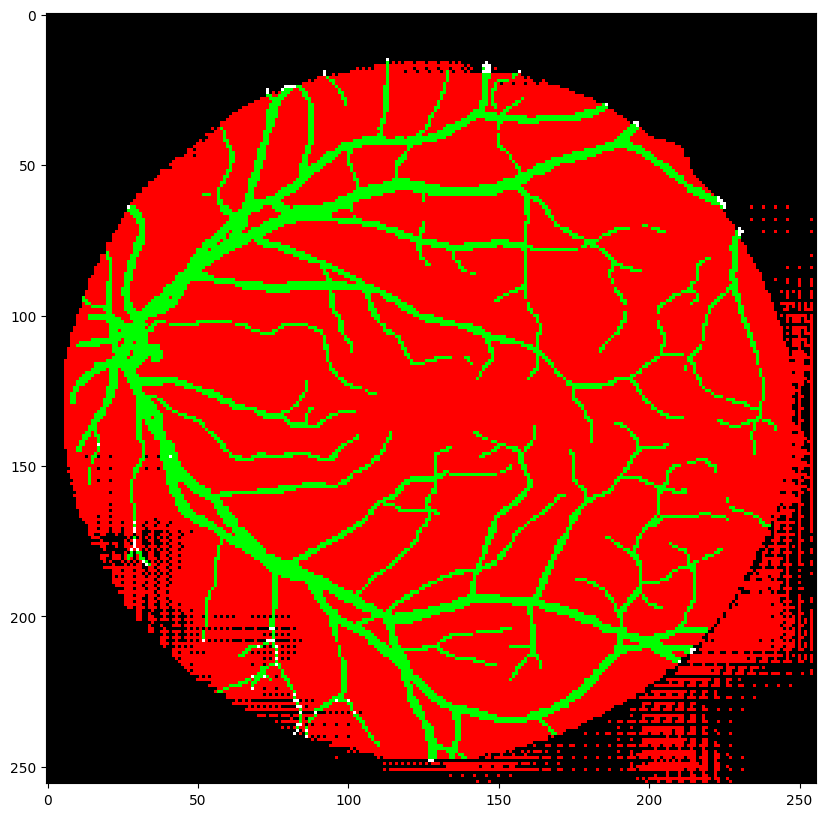

In [9]:
result = ret['visual'][1]
# plot
plt.figure(figsize=(10,10))
plt.imshow(result)

In [ ]:
ims = torch.rand(1,3,1024,1024)
ims = ims.float().cuda()
writer = SummaryWriter(checkpoints_path +'/'+ str(setting)+ '/graph')
writer.add_graph(sam.image_encoder, ims)
writer.close()


c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:372: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:153: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  B = len(x)


In [ ]:
# TRAINING LOOP
b_lr = 0.01
if args.if_warmup:
    b_lr = 0.01

epochs = 80
batch_size = 2

optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.5) #learning rate decay

criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
criterion2 = nn.BCEWithLogitsLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path +'/'+ str(setting)+ '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')

mask_downscale_f = Upsample(scale_factor=0.5)

args.if_warmup = True
args.warmup_period = 20
is_warmup_over = not args.if_warmup
train_data.divide_into_batches(batch_size)
print("Number of batches: ",len(train_data.batches))
print("Elems pr batch: ",len(train_data.batches[0]['image']))


lrs = []
lss = []




for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    train_data.divide_into_batches(batch_size, augment=True)


    b_bar = tqdm(range(len(train_data.batches)))

    for i in b_bar:

        batch = train_data.batches[i]
        imgs = batch['image']
        msks = batch['mask']
        points = batch['points']
        labels = batch['p_labels']


        if args.if_update_encoder:
            img_emb = sammy.encode_img(imgs)
        else:
            with torch.no_grad():
                img_emb = sammy.encode_img(imgs)
        
        sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)

        _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)


        msks = torch.tensor(msks).float().cuda()
        # from Bx512x512 to Bx1x512x512
        msks = msks.unsqueeze(1)
        # from 512x512 to 256x256
        msks = mask_downscale_f(msks)
        
        
        
        loss_dice =  criterion1(pred,msks)
        loss_ce = criterion2(pred,msks)
        loss =  loss_dice + loss_ce


        loss.backward()

        
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        iter_num+=1

    
        # writer.add_scalar('training/total_loss', loss, iter_num)
        # writer.add_scalar('training/loss_ce', loss_ce, iter_num)
        # writer.add_scalar('training/loss_dice', loss_dice, iter_num)


    
    
    train_loss /= (i+1)
    #pbar.set_description('Epoch num {}| train loss {} | lr {} \n'.format(epoch,train_loss,optimizer.param_groups[0]['lr']))

    writer.add_scalar('training/lr', optimizer.param_groups[0]['lr'], epoch)
    writer.add_scalar('training/loss', train_loss, epoch)
    
    print('Epoch num {}| train loss {} | lr_opt {} \n'.format(epoch,round(train_loss, 4),optimizer.param_groups[0]['lr']))

    if not is_warmup_over:
        lss.append(train_loss)
        lrs.append(optimizer.param_groups[0]['lr'])
        if len(lss) > 3:
            b_lr = adjust_lr(lss, lrs)
            #print("adjust_lr:",b_lr)
            if b_lr != optimizer.param_groups[0]['lr']:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = b_lr
                lss = []
                lrs = []
            else:
                lss.pop(0)
                lrs.pop(0)
    else:
        scheduler.step()

    if not is_warmup_over and args.warmup_period < epoch :
        print('***Warmup is over***')
        is_warmup_over = True
        optimizer.param_groups[0]['lr'] = 0.01
        #optimizer = optim.AdamW(sam.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #learning rate decay


    if epoch > 4 and epoch%5==0:
        #eval_loss, dsc = test_model(sam, sammy, val_data, 1)

        sam.eval()

        val_data.divide_into_batches(batch_size, augment=False)

        with torch.no_grad():
            mean_dice = 0
            mean_ce = 0
            mean_both = 0
            for batch in val_data.batches:
                imgs = batch['image']
                msks = batch['mask']
                points = batch['points']
                labels = batch['p_labels']

                img_emb = sammy.encode_img(imgs)
                
                sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)
                _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)

                msks = torch.tensor(msks).float().cuda()
                # from Bx512x512 to Bx1x512x512
                msks = msks.unsqueeze(1)
                # from 512x512 to 256x256
                msks = mask_downscale_f(msks)
                
                loss_dice =  criterion1(pred,msks)
                loss_ce = criterion2(pred,msks)
    
                mean_dice += loss_dice.item()
                mean_ce += loss_ce.item()
                mean_both += (loss_dice + loss_ce).item()


                

            mean_ce /= len(val_data.batches)
            mean_dice /= len(val_data.batches)
            mean_both /= len(val_data.batches)

        from shit import visualize_prediction
        p = pred[0][0].detach().cpu().numpy()
        m = msks[0][0].detach().cpu().numpy()
        ps = points[0]
        visual = visualize_prediction(p,m)
        # plot visual:
        #plt.imshow(visual)
        #plt.show()


        writer.add_image('eval/prediction', visual, epoch, dataformats='HWC')

            
            
            
            
        writer.add_scalar('eval/loss', mean_ce, epoch)
        writer.add_scalar('eval/dice', mean_dice, epoch)
        writer.add_scalar('eval/loss_sum', mean_both, epoch)

        dsc = 1-mean_dice
        
        print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,round(mean_both, 2),dsc))
        if dsc>val_largest_dsc:
            val_largest_dsc = dsc
            last_update_epoch = epoch
            print('largest DSC now: {}'.format(dsc))
            torch.save(sam.state_dict(),checkpoints_path +'/'+ str(setting)+ '/''+checkpoint_best.pth')
        elif (epoch-last_update_epoch)>20:
            # the network haven't been updated for 20 epochs
            print('Training finished###########')
            break
writer.close()

  0%|          | 0/80 [00:00<?, ?it/s]

Start training
Number of batches:  32
Elems pr batch:  2
Epoch num 0


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 0| train loss 0.976 | lr_opt 0.01 

Epoch num 1


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 1| train loss 0.638 | lr_opt 0.01 

Epoch num 2


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 2| train loss 0.5784 | lr_opt 0.01 

Epoch num 3


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 3| train loss 0.5239 | lr_opt 0.01 

No adjustment:  0.0571
Epoch num 4


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 4| train loss 0.4981 | lr_opt 0.01 

No adjustment:  0.0402
Epoch num 5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 5| train loss 0.4921 | lr_opt 0.01 

No adjustment:  0.0159
Eval Epoch num 5 | val loss 0.5 | dsc 0.7063438072800636 

largest DSC now: 0.7063438072800636
Epoch num 6


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 6| train loss 0.4903 | lr_opt 0.01 

Level 2 adjustment:  0.0039  <  0.005
Epoch num 7


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 7| train loss 0.4739 | lr_opt 0.0025 

Epoch num 8


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 8| train loss 0.4697 | lr_opt 0.0025 

Epoch num 9


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 9| train loss 0.4669 | lr_opt 0.0025 

Epoch num 10


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 10| train loss 0.4648 | lr_opt 0.0025 

Level 2 adjustment:  0.0024  <  0.005
Eval Epoch num 10 | val loss 0.46 | dsc 0.7346392497420311 

largest DSC now: 0.7346392497420311
Epoch num 11


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 11| train loss 0.4609 | lr_opt 0.000625 

Epoch num 12


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 12| train loss 0.4588 | lr_opt 0.000625 

Epoch num 13


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 13| train loss 0.4589 | lr_opt 0.000625 

Epoch num 14


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 14| train loss 0.4566 | lr_opt 0.000625 

Level 2 adjustment:  0.0011  <  0.005
Epoch num 15


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 15| train loss 0.4592 | lr_opt 0.00015625 

Eval Epoch num 15 | val loss 0.47 | dsc 0.7233846634626389 

Epoch num 16


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 16| train loss 0.457 | lr_opt 0.00015625 

Epoch num 17


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 17| train loss 0.4573 | lr_opt 0.00015625 

Epoch num 18


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 18| train loss 0.4588 | lr_opt 0.00015625 

Level 2 adjustment:  0.0009  <  0.005
Epoch num 19


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 19| train loss 0.4551 | lr_opt 3.90625e-05 

Epoch num 20


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 20| train loss 0.4566 | lr_opt 3.90625e-05 

Eval Epoch num 20 | val loss 0.45 | dsc 0.7339359372854233 

Epoch num 21


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 21| train loss 0.4566 | lr_opt 3.90625e-05 

***Warmup is over***
Epoch num 22


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 22| train loss 0.4924 | lr_opt 0.01 

Epoch num 23


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 23| train loss 0.4795 | lr_opt 0.01 

Epoch num 24


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 24| train loss 0.4708 | lr_opt 0.01 

Epoch num 25


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 25| train loss 0.4683 | lr_opt 0.01 

Eval Epoch num 25 | val loss 0.47 | dsc 0.717493861913681 

Epoch num 26


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 26| train loss 0.4653 | lr_opt 0.01 

Epoch num 27


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 27| train loss 0.4611 | lr_opt 0.01 

Epoch num 28


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 28| train loss 0.4626 | lr_opt 0.01 

Epoch num 29


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 29| train loss 0.4655 | lr_opt 0.01 

Epoch num 30


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 30| train loss 0.4612 | lr_opt 0.01 

Eval Epoch num 30 | val loss 0.47 | dsc 0.7205570191144943 

Epoch num 31


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 31| train loss 0.4611 | lr_opt 0.01 

Epoch num 32


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 32| train loss 0.4492 | lr_opt 0.005 

Epoch num 33


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 33| train loss 0.4474 | lr_opt 0.005 

Epoch num 34


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 34| train loss 0.4445 | lr_opt 0.005 

Epoch num 35


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 35| train loss 0.4454 | lr_opt 0.005 

Eval Epoch num 35 | val loss 0.44 | dsc 0.7418146803975105 

largest DSC now: 0.7418146803975105
Epoch num 36


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 36| train loss 0.4449 | lr_opt 0.005 

Epoch num 37


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 37| train loss 0.4463 | lr_opt 0.005 

Epoch num 38


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 38| train loss 0.4439 | lr_opt 0.005 

Epoch num 39


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 39| train loss 0.4456 | lr_opt 0.005 

Epoch num 40


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 40| train loss 0.4431 | lr_opt 0.005 

Eval Epoch num 40 | val loss 0.44 | dsc 0.7432220503687859 

largest DSC now: 0.7432220503687859
Epoch num 41


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 41| train loss 0.4417 | lr_opt 0.005 

Epoch num 42


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 42| train loss 0.4392 | lr_opt 0.0025 

Epoch num 43


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 43| train loss 0.4363 | lr_opt 0.0025 

Epoch num 44


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 44| train loss 0.4378 | lr_opt 0.0025 

Epoch num 45


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 45| train loss 0.4374 | lr_opt 0.0025 

Eval Epoch num 45 | val loss 0.43 | dsc 0.7509407997131348 

largest DSC now: 0.7509407997131348
Epoch num 46


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 46| train loss 0.4355 | lr_opt 0.0025 

Epoch num 47


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 47| train loss 0.4357 | lr_opt 0.0025 

Epoch num 48


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 48| train loss 0.4354 | lr_opt 0.0025 

Epoch num 49


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 49| train loss 0.4384 | lr_opt 0.0025 

Epoch num 50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 50| train loss 0.435 | lr_opt 0.0025 

Eval Epoch num 50 | val loss 0.43 | dsc 0.7513677850365639 

largest DSC now: 0.7513677850365639
Epoch num 51


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 51| train loss 0.4375 | lr_opt 0.0025 

Epoch num 52


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 52| train loss 0.4296 | lr_opt 0.00125 

Epoch num 53


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 53| train loss 0.432 | lr_opt 0.00125 

Epoch num 54


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 54| train loss 0.4322 | lr_opt 0.00125 

Epoch num 55


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 55| train loss 0.4292 | lr_opt 0.00125 

Eval Epoch num 55 | val loss 0.43 | dsc 0.7526735812425613 

largest DSC now: 0.7526735812425613
Epoch num 56


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 56| train loss 0.4317 | lr_opt 0.00125 

Epoch num 57


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 57| train loss 0.4323 | lr_opt 0.00125 

Epoch num 58


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 58| train loss 0.4339 | lr_opt 0.00125 

Epoch num 59


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 59| train loss 0.4299 | lr_opt 0.00125 

Epoch num 60


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 60| train loss 0.4282 | lr_opt 0.00125 

Eval Epoch num 60 | val loss 0.43 | dsc 0.7553766742348671 

largest DSC now: 0.7553766742348671
Epoch num 61


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 61| train loss 0.4292 | lr_opt 0.00125 

Epoch num 62


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 62| train loss 0.4279 | lr_opt 0.000625 

Epoch num 63


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 63| train loss 0.4254 | lr_opt 0.000625 

Epoch num 64


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 64| train loss 0.4277 | lr_opt 0.000625 

Epoch num 65


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 65| train loss 0.4295 | lr_opt 0.000625 

Eval Epoch num 65 | val loss 0.44 | dsc 0.7445602416992188 

Epoch num 66


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 66| train loss 0.4254 | lr_opt 0.000625 

Epoch num 67


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 67| train loss 0.427 | lr_opt 0.000625 

Epoch num 68


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 68| train loss 0.4269 | lr_opt 0.000625 

Epoch num 69


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 69| train loss 0.4279 | lr_opt 0.000625 

Epoch num 70


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 70| train loss 0.4287 | lr_opt 0.000625 

Eval Epoch num 70 | val loss 0.44 | dsc 0.74330984801054 

Epoch num 71


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 71| train loss 0.4279 | lr_opt 0.000625 

Epoch num 72


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 72| train loss 0.4248 | lr_opt 0.0003125 

Epoch num 73


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 73| train loss 0.4262 | lr_opt 0.0003125 

Epoch num 74


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 74| train loss 0.4246 | lr_opt 0.0003125 

Epoch num 75


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 75| train loss 0.4259 | lr_opt 0.0003125 

Eval Epoch num 75 | val loss 0.43 | dsc 0.7451397329568863 

Epoch num 76


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 76| train loss 0.4255 | lr_opt 0.0003125 

Epoch num 77


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 77| train loss 0.4268 | lr_opt 0.0003125 

Epoch num 78


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 78| train loss 0.4256 | lr_opt 0.0003125 

Epoch num 79


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch num 79| train loss 0.4273 | lr_opt 0.0003125 



In [ ]:
#try counting more !


from shit import test_model
with open('test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

test_data = EyeData(test_data)
test_model(sam,sammy,test_data,1)

c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\losses\dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


Eval Loss: 0.42271931916475297, DSC: 0.18162553310394286, CE: 0.2410937875509262


(0.2410937875509262, 0.18162553310394286, 0.42271931916475297)

In [ ]:
test_model(sam,sammy,val_data,len(val_data))

Eval Loss: 0.3834812641143799, DSC: 0.16800659894943237, CE: 0.2154746651649475


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\losses\dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


(0.2154746651649475, 0.16800659894943237, 0.3834812641143799)

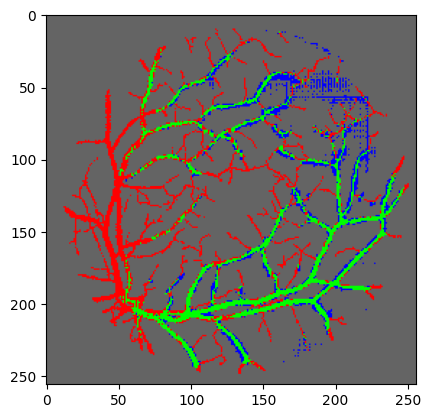

In [ ]:
p = pred[1][0].detach().cpu().numpy()
m = msks[1][0].detach().cpu().numpy()
p = np.where(p > 0.5, 1, 0)
m = np.where(m > 0, 1, 0)
im = np.full((256,256,3),100)
# color green where m == p == 1
im[np.where((m==1) & (p==1))] = [0,255,0]
# color red where m == 1 and p == 0
im[np.where((m==1) & (p==0))] = [255,0,0]
# color blue where m == 0 and p == 1
im[np.where((m==0) & (p==1))] = [0,0,255]


# plot the mask
plt.imshow(im)